
# Origin of Replication Finder

## A Bioinformatic Algorithm to Find the Origin of Replication on Bacterial Genomes

Because of the molecular mechanics of bacterial division, [GC-skew](gc skew) reaches a minimum around the origin of replication. This algorithm scans for consensus sequences around this region.

#### Settings

In [1]:
window_length = 1000
k_mer_length = 9
max_mismatches_allowed = 1

#### Import dependencies and declare constants

In [2]:
import regex
from pandas import DataFrame
from collections import defaultdict
from os.path import isfile
from urllib.request import urlretrieve
from helpers import *
%matplotlib inline

nucleotide_to_delta_skew = {'A': 0, 'C': -1, 'T': 0, 'G': 1, 'N': 0}

#### Read genome and calculate the GC skew curve

In [3]:
genome_fp = 'E_coli_genome.fas'

if not isfile(genome_fp):
    urlretrieve('https://www.genome.wisc.edu/pub/sequence/U00096.2.fas', genome_fp)

with open(genome_fp, 'r') as f:
    # Load genome as FASTA file
    genome = ''.join(line.strip().upper() for line in f if not line.startswith('>'))
df = DataFrame({'Delta_Skew': [nucleotide_to_delta_skew[n] for n in genome]})
df['Skew'] = df['Delta_Skew'].cumsum()

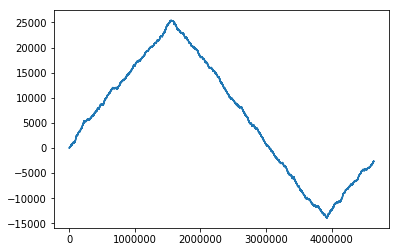

In [4]:
df['Skew'].plot()

There is a clear GC skew minimum.

#### Calculate the precise minimum

In [5]:
minimum_skew = df['Skew'].min()
minimum_skew_locations = [int(l) for l in df[df['Skew'] == minimum_skew].index \
                          if df.loc[l]['Delta_Skew'] == -1]

Now that we know where in the genome to took, we need two more functions to find k-mers with the greatest number of aproximate matches.
1. To return a subset or 'window' of the genome around the GC skew minimum
1. Scan for the most frequent kmers in this window

In [6]:
def window_centered_around(_center, _window_length, _genome):    
    return _genome[int(_center - _window_length / 2):int(_center + (_window_length / 2))]

def most_frequent_kmers(_sequence, _k_mer_length, _max_mismatches):
    '''
    Returns the kmers with the greatest number of hits and the
    number of those hits
    '''
    
    def sequence_neighborhood(pattern, max_mismatches_allowed):
        '''
        Returns a 'neighborhood' of sequences where there are a defined
        number of mismatches with the seed sequence
        '''
    
        substitutes = {'A': ['C', 'T', 'G'],
                       'T': ['A', 'C', 'G'],
                       'G': ['A', 'T', 'C'],
                       'C': ['A', 'T', 'G'],
                       'N': ['C', 'A', 'T', 'G']}
    
        def sequences_with_one_mismatch(pattern):

            sequences = set([pattern])

            for i, nucleotide in enumerate(pattern):
                for substitute_nucleotide in substitutes[nucleotide]:
                    new_neighbor = pattern[:i] + substitute_nucleotide + pattern[i + 1:]
                    sequences.add(new_neighbor)

            return list(sequences)

        neighborhood = set([pattern])

        for i in range(max_mismatches_allowed):
            new_neighbors = [sequences_with_one_mismatch(neighbor) for neighbor in neighborhood]
            neighborhood.update(flatten(new_neighbors))

        return neighborhood
        
    def num_approx_matches(_in_sequence, _of_kmer, max_mismatches_allowed):
        '''
        Compares two sequence and returns the number of times there is an
        aproximate match, defined by having at most a defined number of
        mismatches
        '''
        search_expression = '(%s){s<=%s}' % (_of_kmer, max_mismatches_allowed)
        occurrences = regex.findall(search_expression, _in_sequence)
        return len(occurrences)
        
    possible_kmers = set([])

    for sequence in Subsequences(_sequence, _k_mer_length):
        possible_kmers.update(sequence_neighborhood(sequence, _max_mismatches))

    k_mer_hits = defaultdict(list)
    
    for kmer in possible_kmers:
        forward_hits = num_approx_matches(_sequence, kmer, _max_mismatches)
        reverse_complement_hits = num_approx_matches(_sequence, reverse_complement(kmer), _max_mismatches)
        k_mer_hits[forward_hits + reverse_complement_hits].append(kmer)
        
    number_of_top_hits = max(k_mer_hits.keys())
    top_hits = k_mer_hits[number_of_top_hits]
    
    return number_of_top_hits, top_hits

With these functions defined, we may iterate over the windows centered around these GC skew minimums and search for aproximate matches. The k-mer with the most matches in likely the origin of replication.

In [7]:
for min_skew_loc in minimum_skew_locations:
    window = window_centered_around(min_skew_loc, window_length, genome)
    number_of_top_hits, top_hits = most_frequent_kmers(window, k_mer_length, max_mismatches_allowed)
    
    if(number_of_top_hits > 0):
        print('Found the following polymers centered around {} bp:'.format(min_skew_loc))
        for hit in top_hits:
            print('\t* {} [{} hits]'.format(hit, number_of_top_hits))
    else:
        print('Found nothing.')

Found the following polymers centered around 3923619 bp:
	* GATCAACAG [7 hits]
	* CTGTTGATC [7 hits]


Indeed, if the sample genome was used, this is the origin of replication for _E. coli._